In [476]:
import numpy as np
import pandas as pd
import chess
import chess.pgn
from tqdm import tqdm

In [148]:
games_arr = []
with open("data/CCRL-4040.[952777].pgn") as pgn:
    for i in tqdm(range(952777)):
        games_arr += [chess.pgn.read_game(pgn)]

 51%|█████     | 481965/952777 [42:21<41:23, 189.60it/s]  

KeyboardInterrupt: 

In [150]:
i

481970

In [154]:
import pickle
with open('data/CCRL_part1.pickle', 'wb') as f:
    pickle.dump(np.array(games_arr), f)

RecursionError: maximum recursion depth exceeded while pickling an object

In [477]:
from utils import ohe_board, move2tensor, tensor2move

In [478]:
def get_position(game, n):
    k = 0
    for i in game.mainline():
        if k == n:
            break
        k += 1
    return i

In [15]:
pgn = open("data/CCRL-4040.[952777].pgn")

In [16]:
game = chess.pgn.read_game(pgn)

In [17]:
game.headers['PlyCount']

'83'

In [479]:
def keras_generator():
    pgn = open("data/CCRL-4040.[952777].pgn")
    while(1):
        x_batch = []
        y_batch = []
        try:
            game = chess.pgn.read_game(pgn)
        except:
            pgn = open("data/CCRL-4040.[952777].pgn")
            game = chess.pgn.read_game(pgn)

        for move_id in np.random.choice(list(range(0, int(game.headers['PlyCount']) - 1, 2)), 32):
            position = get_position(game, move_id)
            white_ohe = ohe_board(position.parent.board(), white=True)
            black_ohe = ohe_board(position.parent.board(), white=False)

            feat_tensor = np.concatenate([white_ohe, black_ohe], axis=-1)
            move_str = position.move.__str__()
            move_tensor = move2tensor(move_str)

            x_batch += [feat_tensor]
            y_batch += [move_tensor]

        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, y_batch

In [480]:
for x, y in keras_generator():
    break

In [481]:
x.shape

(32, 8, 8, 12)

In [482]:
y.shape

(32, 8, 8, 81)

In [290]:
x.sum(axis=(1,2,3))

array([18.,  7.,  7., 28.,  5., 28., 12., 31.,  7., 13., 15.,  9.,  7.,
       31., 18.,  7.])

In [9]:
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D
import keras

inp = Input(shape=(8, 8, 12))
conv_1 = Conv2D(512, (3,3), padding='same')(inp)
conv_1 = Conv2D(512, (3,3), padding='same')(conv_1)
conv_1 = Activation('relu')(conv_1)

conv_2 = Conv2D(256, (3,3), padding='same')(conv_1)
conv_2 = Conv2D(256, (3,3), padding='same')(conv_2)
conv_2 = Activation('relu')(conv_2)

conv_3 = Conv2D(128, (3,3), padding='same')(conv_2)
conv_3 = Conv2D(128, (3,3), padding='same')(conv_3)
conv_3 = Activation('relu')(conv_3)

conv_4 = Conv2D(81, (3,3), padding='same')(conv_3)
conv_4 = Conv2D(81, (3,3), padding='same')(conv_4)
result = Activation('sigmoid')(conv_4)


model = Model(inputs=inp, outputs=result)

Using TensorFlow backend.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 512)         55808     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         2359808   
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         1179904   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 256)         0         
__________

In [81]:
best_w = keras.callbacks.ModelCheckpoint('best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [334]:
batch_size = 16
model.fit_generator(keras_generator(),
              steps_per_epoch=20000,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(),
              validation_steps=2000,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
20000/20000 [==============================] - 758s 38ms/step - loss: 6.0082e-04 - val_loss: 6.1371e-04
Epoch 2/100
20000/20000 [==============================] - 762s 38ms/step - loss: 6.0651e-04 - val_loss: 6.0523e-04
Epoch 3/100
20000/20000 [==============================] - 756s 38ms/step - loss: 5.9345e-04 - val_loss: 5.8990e-04
Epoch 4/100
20000/20000 [==============================] - 756s 38ms/step - loss: 6.0759e-04 - val_loss: 5.8793e-04
Epoch 5/100
20000/20000 [==============================] - 760s 38ms/step - loss: 6.0641e-04 - val_loss: 5.9916e-04
Epoch 6/100
20000/20000 [==============================] - 772s 39ms/step - loss: 5.9939e-04 - val_loss: 5.8847e-04
Epoch 7/100
20000/20000 [==============================] - 775s 39ms/step - loss: 6.0480e-04 - val_loss: 5.8849e-04
Epoch 8/100
20000/20000 [==============================] - 767s 38ms/step - loss: 6.0771e-04 - val_loss: 5.8354e-04
Epoch 9/100
20000/20000 [==============================] - 764s 38ms/ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 750s 37ms/step - loss: 6.0176e-04 - val_loss: 5.7514e-04
Epoch 27/100
  592/20000 [..............................] - ETA: 10:54 - loss: 5.9910e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 749s 37ms/step - loss: 5.9880e-04 - val_loss: 5.7280e-04
Epoch 28/100
 4853/20000 [======>.......................] - ETA: 8:41 - loss: 5.9786e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9194/20000 [============>.................] - ETA: 6:04 - loss: 5.9553e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13720/20000 [===================>..........] - ETA: 3:34 - loss: 5.9040e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18277/20000 [==========================>...] - ETA: 58s - loss: 5.9084e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 739s 37ms/step - loss: 5.9170e-04 - val_loss: 5.8040e-04
Epoch 33/100
 3017/20000 [===>..........................] - ETA: 9:26 - loss: 5.9191e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 7551/20000 [==========>...................] - ETA: 6:58 - loss: 5.8767e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11925/20000 [================>.............] - ETA: 4:29 - loss: 5.9224e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16267/20000 [=======================>......] - ETA: 2:05 - loss: 5.8888e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 734s 37ms/step - loss: 5.8956e-04 - val_loss: 5.7850e-04
Epoch 38/100
  609/20000 [..............................] - ETA: 10:37 - loss: 5.8115e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 731s 37ms/step - loss: 5.9221e-04 - val_loss: 5.8239e-04
Epoch 39/100
 4895/20000 [======>.......................] - ETA: 8:56 - loss: 5.9603e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8752/20000 [============>.................] - ETA: 6:36 - loss: 5.9749e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12821/20000 [==================>...........] - ETA: 4:09 - loss: 5.9596e-0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16885/20000 [========================>.....] - ETA: 1:48 - loss: 5.9264e-04- ETA: 1:50

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 767s 38ms/step - loss: 5.9701e-04 - val_loss: 5.8459e-04
Epoch 44/100


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 749s 37ms/step - loss: 5.9613e-04 - val_loss: 5.7532e-04
Epoch 45/100
 4683/20000 [======>.......................] - ETA: 8:55 - loss: 5.9460e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8897/20000 [============>.................] - ETA: 6:10 - loss: 5.9357e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13022/20000 [==================>...........] - ETA: 4:04 - loss: 5.8284e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12777/20000 [==================>...........] - ETA: 4:12 - loss: 5.9134e-04

KeyboardInterrupt: 

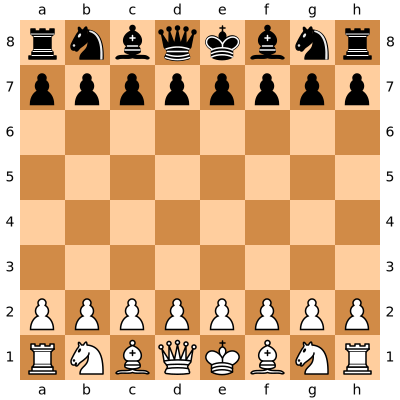

In [335]:
game.board()

In [336]:
board = chess.Board()

In [474]:
board.push(chess.Move.from_uci('c4c5'))

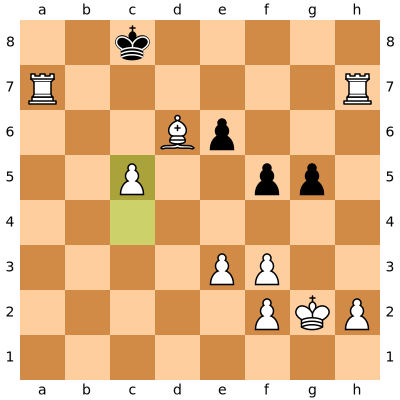

In [475]:
board

In [473]:
#position = get_position(game, 80)
white_ohe = ohe_board(board, white=True)
black_ohe = ohe_board(board, white=False)

feat_tensor = np.concatenate([white_ohe, black_ohe], axis=-1)

ohe = np.expand_dims(feat_tensor, axis=0)
pred = model.predict(ohe)

print('{} : {}'.format(tensor2move(pred[0]), pred[0].max()))

c4c5 : 0.43360036611557007


In [308]:
(pred[0] == 0.27716219425201416).max()

True

In [311]:
tensor2move((1 - (pred[0] == 0.27716219425201416) ) * pred[0])

'c3d2'

In [111]:
pred[0].max()

0.97227097

In [112]:
tensor2move(pred[0])

'g1f3'